In [3]:
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

import pandas as pd
import matplotlib.pyplot as plt
import math
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load data
path = 'data/technology/SAM.csv'
df = pd.read_csv(path, index_col=6, delimiter='\t')
close=df[['Close']]
close.head(10)

,Close
TradingDate,
2001-01-03,1424.0
2001-01-05,1449.0
2001-01-08,1474.0
2001-01-10,1504.0
2001-01-12,1533.0
2001-01-15,1533.0
2001-01-17,1563.0
2001-01-19,1592.0
2001-01-29,1622.0


**ARIMA MODEL**

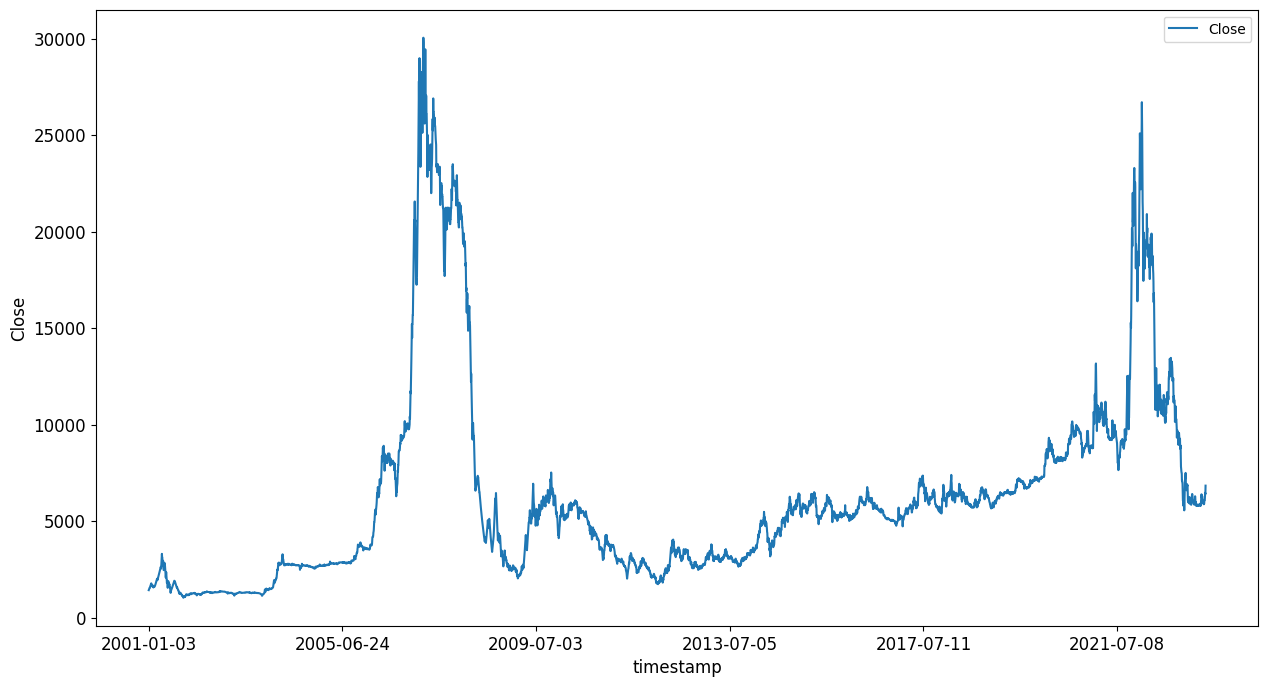

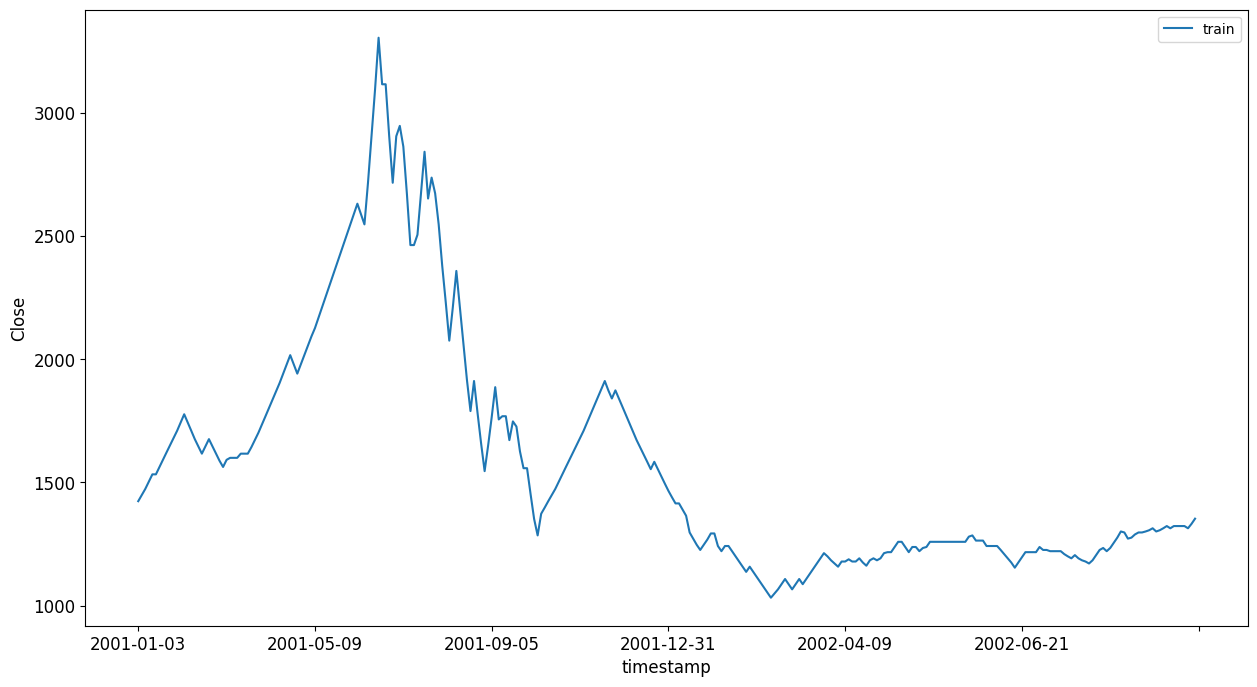

In [5]:
close.plot(y='Close', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

# Load 300 data
close[:300][['Close']].rename(columns={'Close':'train'}) \
    .plot(y=['train'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

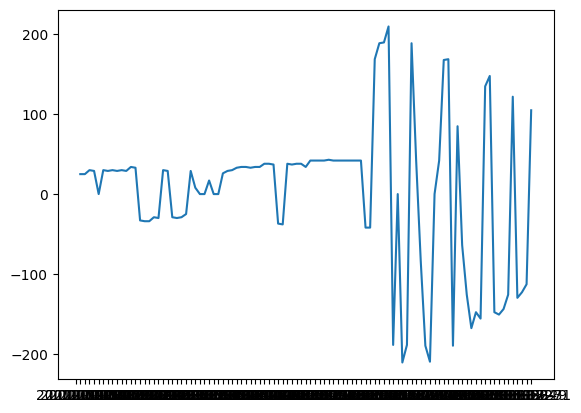

In [6]:
plt.plot(close[:100].diff())

**Create training and testing data sets**

Training data shape:  (3820, 1)
Test data shape:  (1638, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

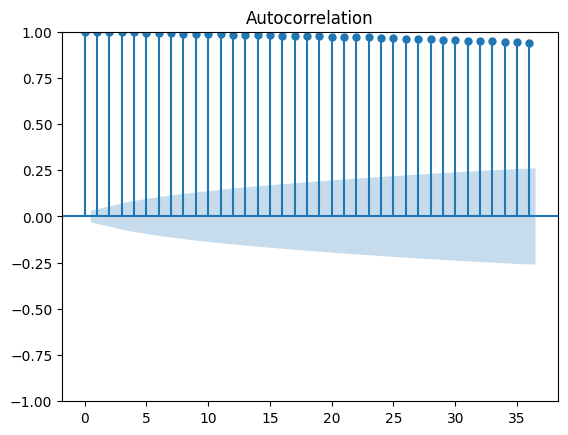

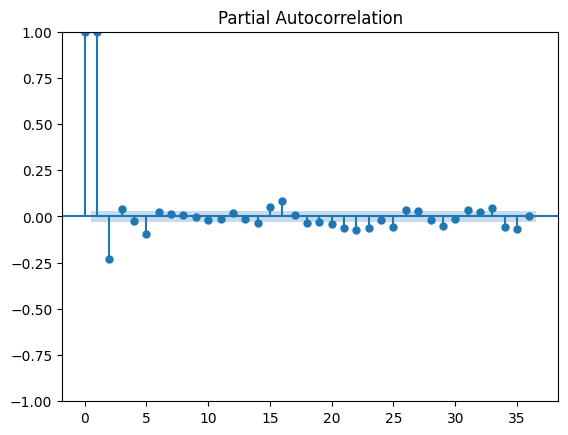

In [7]:
n = int(len(df) * 0.7)
m = int(len(df) * 0.7)

df_train = close.copy()[:n][['Close']]
df_test = close.copy()[m:][['Close']]

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)

plot_acf(df_train['Close'])
plot_pacf(df_train['Close'])
plt.show

**Data prepatation**

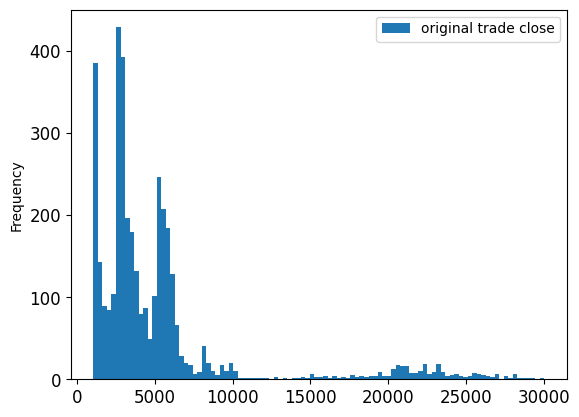

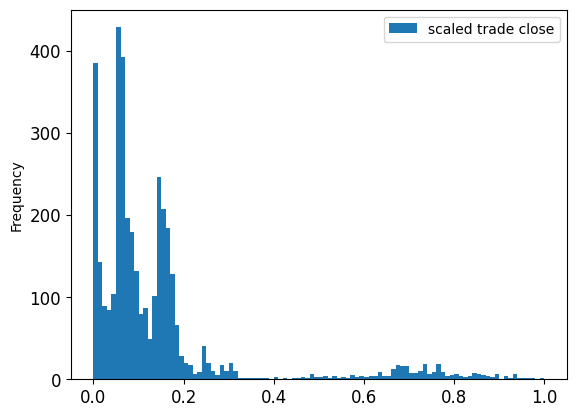

In [8]:
#SCALE TRAIN 
scaler=MinMaxScaler()
df_train['Close']=scaler.fit_transform(df_train)

close[:n][['Close']].rename(columns={'Close':'original trade close'}).plot.hist(bins=100, fontsize=12)
df_train.rename(columns={'Close':'scaled trade close'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [9]:
# SCALE TEST
df_test['Close'] = scaler.transform(df_test)
df_test.head()

,Close
TradingDate,
2016-10-19,0.140386
2016-10-20,0.141041
2016-10-21,0.141041
2016-10-24,0.140386
2016-10-25,0.139318


**Implement ARIMA method**

In [10]:
# Specify the number of steps to forcast ahead
HORIZON=6
print('Forescating horizon:', HORIZON, 'days')

Forescating horizon: 6 days


In [11]:
df_test_shifted = df_test.copy()

for t in range(1, HORIZON):
    df_test_shifted['Close+'+str(t)] = df_test_shifted['Close'].shift(-t)

df_test_shifted=df_test_shifted.dropna(how='any')
df_test_shifted.head(5)

,Close,Close+1,Close+2,Close+3,Close+4,Close+5
TradingDate,,,,,,
2016-10-19,0.140386,0.141041,0.141041,0.140386,0.139318,0.139318
2016-10-20,0.141041,0.141041,0.140386,0.139318,0.139318,0.139318
2016-10-21,0.141041,0.140386,0.139318,0.139318,0.139318,0.139318
2016-10-24,0.140386,0.139318,0.139318,0.139318,0.139318,0.138870
2016-10-25,0.139318,0.139318,0.139318,0.139318,0.138870,0.138456


In [12]:
order=(1,1,1)
model=ARIMA(df_train,order=order)
results=model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3820
Model:                 ARIMA(1, 1, 1)   Log Likelihood               13628.435
Date:                Mon, 19 Jun 2023   AIC                         -27250.870
Time:                        13:08:10   BIC                         -27232.127
Sample:                             0   HQIC                        -27244.210
                               - 3820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0462      0.017      2.701      0.007       0.013       0.080
ma.L1          0.2214      0.017     12.979      0.000       0.188       0.255
sigma2      4.653e-05   3.48e-07    133.725      0.0

In [13]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts_data):
    
    # Q1 **********************Hoàn thành đoạn code sau đây*************
    # Rolling statistics
    roll_mean = ts_data.rolling(30, center=True, closed='both').mean()
    roll_std = ts_data.rolling(5, center=True, closed='both').std()
    #****************************************************************
    
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

In [14]:
df.index = pd.to_datetime(df.index, format="%Y-%M-%d")
df_final = pd.Series(df['Close'])
type(df_final)

pandas.core.series.Series

Dickey-Fuller test results

Test Statistic      -2.461816
p-value              0.125043
# of lags           32.000000
# of obs          5425.000000
dtype: float64
Critical value at 1%: -3.43156
Critical value at 5%: -2.86207
Critical value at 10%: -2.56705


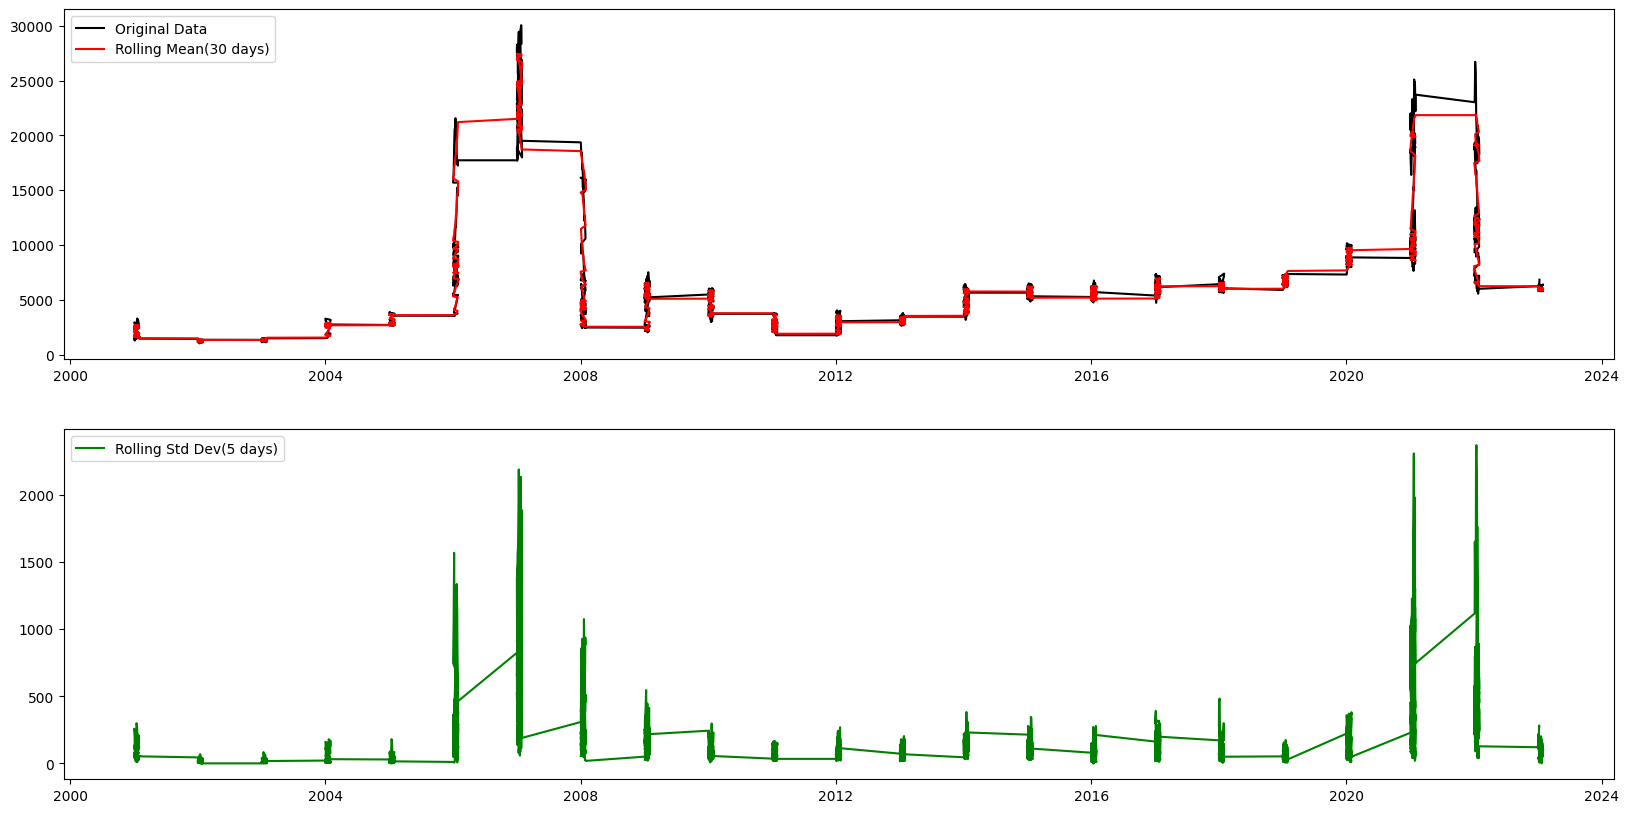

In [15]:
check_stationarity(df_final)

$\rightarrow$ Unstationaried data

In [16]:
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic   -1.139093e+01
p-value           8.071546e-21
# of lags         3.300000e+01
# of obs          5.423000e+03
dtype: float64
Critical value at 1%: -3.43156
Critical value at 5%: -2.86207
Critical value at 10%: -2.56705


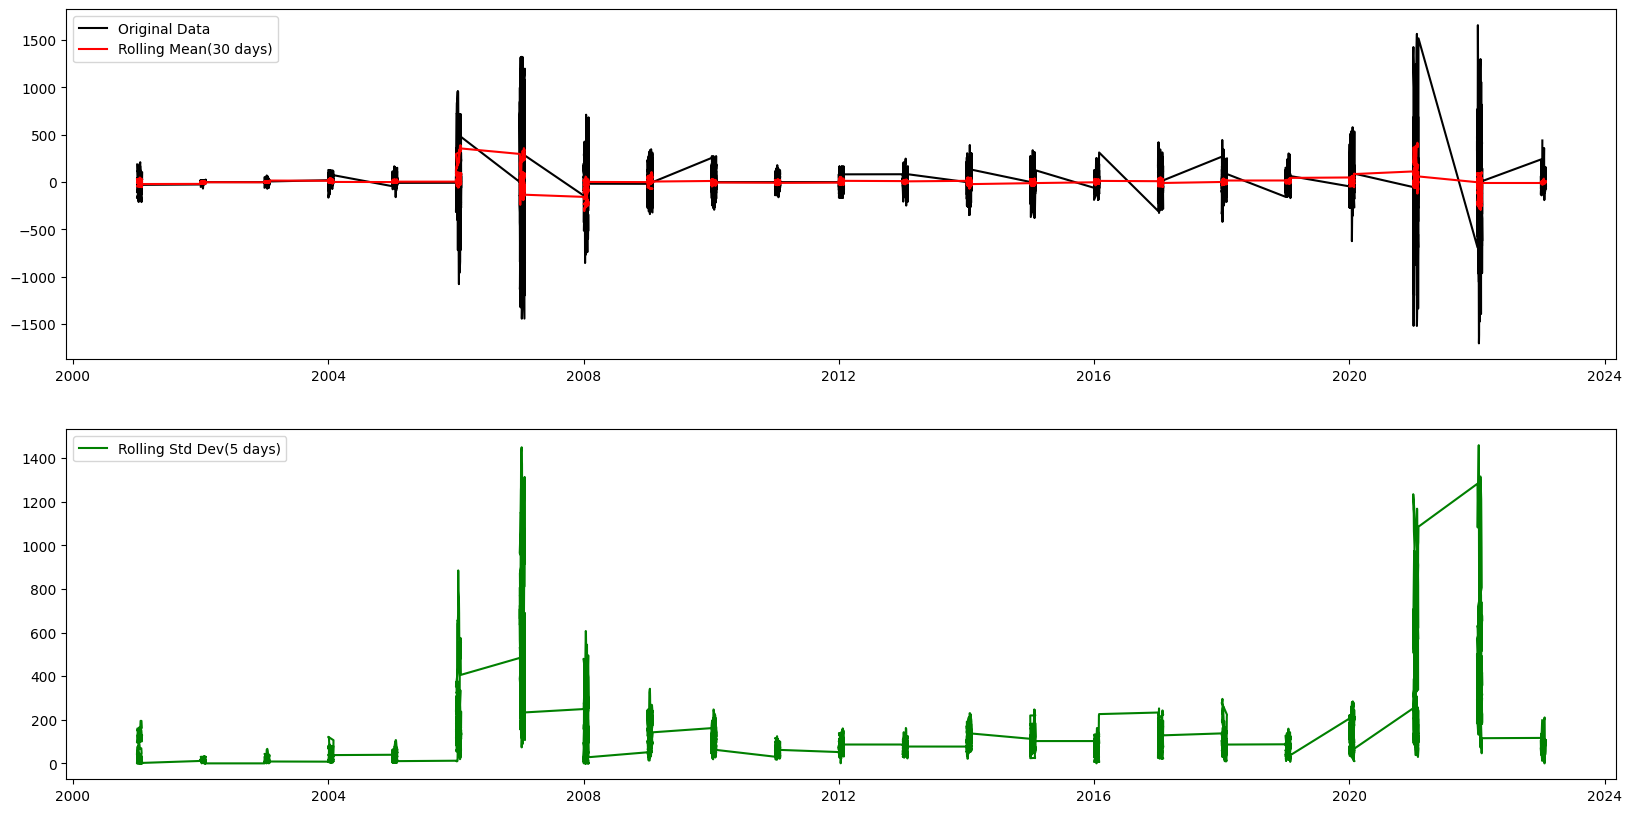

In [17]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

$\rightarrow$ Stationaried data

**Evaluate the model**

In [18]:
training_window= 30 # dedicate 30 days for training

train_ts=df_train['Close']
test_ts=df_test_shifted

history=[x for x in train_ts]
history=history[(-training_window):]

predictions=list()

for i in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=HORIZON)
    predictions.append(output)
    obs=list(test_ts.iloc[i])
    history.append(obs[0])
    history.pop(0)

In [19]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.024


In [20]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = df_test.index[0:len(df_test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2016-10-19,t+1,5122.504013,5106.0
1,2016-10-20,t+1,5105.678983,5125.0
2,2016-10-21,t+1,5124.043208,5125.0
3,2016-10-24,t+1,5126.556676,5106.0
4,2016-10-25,t+1,5109.045643,5075.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


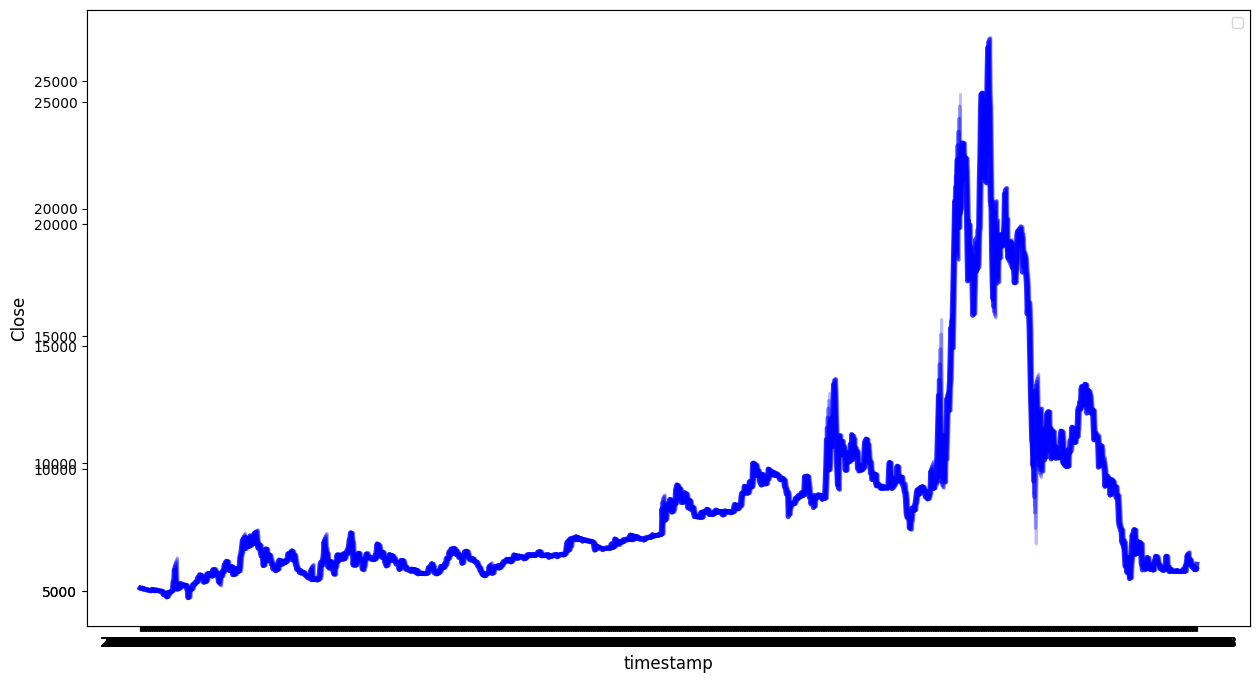

In [21]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()